# Word2Vec then RNN

## Imports and setting up TensorBoard

In [1]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc
from tensorflow.python.client import device_lib
from keras_train_helper import rotateTensorboardLogs
from keras.callbacks import TensorBoard
from keras_train_helper import PrintAucCallback

tensorBoardCallback = TensorBoard(log_dir="./tb-logs")
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4401543046536381601
]


## Loading data and setting up preprocessing tools

In [2]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


In [3]:
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
allWords = pd.concat([splitter.transform(allData), splitter.transform(contestTest)])
w2i = Word2Int(allWords)
zeroPadder = ZeroPadder(maxSeqLength)

preparationPipeline = Pipeline(steps=[
    ("split", splitter),
    ("w2i", w2i),
    ("zeroPadding", zeroPadder) ])

Splitting sentences...
Splitting sentences...
Loading w2i and i2w dictionaries...


In [4]:
%%time
w2v = Word2Vec(50, allWords, w2i.w2i, seed=4324)
embeddingMatrix, i2v = w2v.embeddingMatrix()

Loading word2vec dictionary...


## Define the model

### Define the model

In [22]:
lstmUnits = [100]
numClasses = 2
batchSize = 1024

def defineModel():
    model = Sequential()

    model.add(Embedding(
        embeddingMatrix.shape[0],
        embeddingMatrix.shape[1],
        weights=[embeddingMatrix],
        input_length=maxSeqLength,
        trainable=False))

    model.add(Bidirectional(LSTM(lstmUnits[0]), name="LSTM"))

    model.add(Dropout(.2, name="dropout"))

    model.add(Dense(
        2, 
        activation="softmax", 
        name="softmax_output"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="nadam", 
        metrics=[tfauc])

    print(model.summary())
    return model

## Prepare data and train the model

In [34]:
def trainModel(trainDataset, testDataset, label, epochs, fast=False):
    print("Building model for target variable: {}".format(label))
    model = defineModel()
    
    tf.set_random_seed(43245)
    np.random.seed(453252)
    
    labelizer = Labelizer(label)
    oversampler = Oversampler(label)
    
    trainOversampled = oversampler.transform(trainDataset)

    trainSentences = preparationPipeline.transform(trainOversampled)[:1000]
    trainLabels = labelizer.transform(trainOversampled)[:1000]
    testSentences = preparationPipeline.transform(testDataset)[:1000]
    testLabels = labelizer.transform(testDataset)[:1000]

    printAucCallback = PrintAucCallback(testSentences, testLabels, allTestDataPerEpochs=1)
    if fast:
        callbacks = []
    else:
        callbacks = [tensorBoardCallback, printAucCallback]
    
    model.fit(
        trainSentences, 
        trainLabels, 
        nb_epoch=epochs, 
        batch_size=batchSize,
        callbacks=callbacks)
    
    return model

In [33]:
contestModels = [trainModel("toxic", 2), trainModel("severe_toxic", 2), trainModel("obscene", 1), trainModel("threat", 3), trainModel("insult", 2), trainModel("identity_hate", 2)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 50)           19255800  
_________________________________________________________________
LSTM (Bidirectional)         (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 402       
Total params: 19,377,002
Trainable params: 121,202
Non-trainable params: 19,255,800
_________________________________________________________________
None
Oversampling...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...


/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/2
 - all-test-data-auc: 0.5441
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5858 - tfauc: 0.8879
Epoch 2/2
 - all-test-data-auc: 0.5722
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3546 - tfauc: 0.9026
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 50)           19255800  
_________________________________________________________________
LSTM (Bidirectional)         (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 402       
Total params: 19,377,002
Trainable params: 121,202
Non-trainable params: 19,255,800
________________________________________________________________

In [38]:
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
contestPredictionProbabilities = {category: model.predict(preparationPipeline.transform(contestTest[:1000])) for (category, model) in zip(categories, contestModels)}

Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...


In [41]:
suffledResult = pd.DataFrame(dict(
    [("id", contestTest[:1000].id)] 
    + [(name, preds[:, 1]) for (name, preds) in contestPredictionProbabilities.items()]))

result = suffledResult[["id"] + categories]

In [44]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.144361,0.123908,0.221225,0.076695,0.149220,0.124009
1,0000247867823ef7,0.108567,0.090323,0.188991,0.044283,0.139559,0.090474
2,00013b17ad220c46,0.107743,0.057440,0.136317,0.038321,0.078102,0.057150
3,00017563c3f7919a,0.124505,0.134712,0.252164,0.060358,0.138578,0.133665
4,00017695ad8997eb,0.101759,0.080832,0.183596,0.036246,0.103686,0.080453


In [45]:
result.to_csv("./submissions/w2v-then-rnn.csv", index=False)

## Evaluate on test data

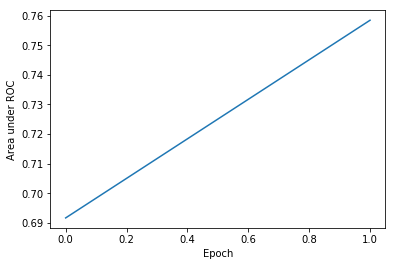

In [20]:
import matplotlib.pyplot as plt
plt.plot([value for key, value in printAucCallback.listOfAucs])

plt.ylabel("Area under ROC")
plt.xlabel("Epoch")
plt.show()

           P Neutral  P Toxic
T Neutral       8997       24
T Toxic          929       50


           P Neutral  P Toxic
T Neutral     0.8997   0.0024
T Toxic       0.0929   0.0050


0.095


0.2795


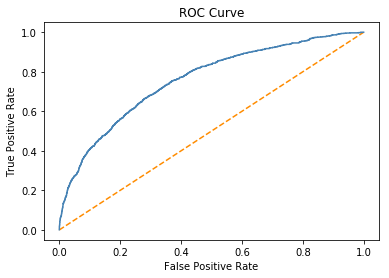

In [21]:
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)